In [1]:
import numpy as np
import pandas as pd
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '../data/v1'
fps = 10

## Load Data

In [3]:
trial = pd.read_csv(os.path.join(data_dir, 'experiment_settings.csv'))
trial.head(5)                    

,pull,gene,line,genotype,sex,phase,odor,seed,date,time,annotator,video,label,merge,mice,identity,notes,fps,duration (sec)
0,rd25,a,ash1l,wt,m,H,S,1,12/2/2024,15:34:27,SD,a_m_1_S_H.mp4,a_m_1_S_H.csv,0,4,1,NaN,10,1800
1,rd25,a,ash1l,wt,m,O,S,1,12/2/2024,16:05:34,SD,a_m_1_S_O.mp4,a_m_1_S_O.csv,0,4,1,NaN,10,900
2,rd25,a,ash1l,wt,m,P,S,1,12/2/2024,16:24:37,SD,a_m_1_S_P.mp4,a_m_1_S_P.csv,0,4,1,NaN,10,900
3,rd25,a,ash1l,wt,m,H,F,1,12/2/2024,16:42:33,SD,a_m_1_F_H.mp4,a_m_1_F_H.csv,0,4,1,NaN,10,1800
4,rd25,a,ash1l,wt,m,O,F,1,12/2/2024,17:16:45,SD,a_m_1_F_O.mp4,a_m_1_F_O.csv,0,4,1,NaN,10,900


#### Check Missing Files

In [4]:
def check_files(row, type='video'):
    if type == 'label':
        file = f"{data_dir}/behaviour/{row[type]}"
    else:
        file = f"{data_dir}/video/{row[type]}"
    return os.path.exists(file) 

# list missing videos names
missing_videos = trial[trial.apply(lambda x: check_files(x, type='video'), axis=1) == False]['video'].unique()
missing_videos = pd.DataFrame(missing_videos, columns=['video'])
print(f"Missing Videos ({len(missing_videos)}):", list(missing_videos["video"]))

# list missing label names
missing_labels = trial[trial.apply(lambda x: check_files(x, type='label'), axis=1) == False]['label'].unique()
missing_labels = pd.DataFrame(missing_labels, columns=['label'])
print(f"Missing labels ({len(missing_labels)}):", list(missing_labels["label"]))

Missing Videos (0): []
Missing labels (0): []


#### Check Videos details

In [5]:
def get_video_fps(video_path):
    cap = cv2.VideoCapture(video_path)
    return cap.get(cv2.CAP_PROP_FPS)
def get_video_time(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        print(f"Warning: FPS is 0 for video: {video_path}")
        return 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return int(total_frames/fps)

check_fps = (trial["fps"]==trial["video"].apply(lambda x: get_video_fps(os.path.join(data_dir, 'video', x)))).all()
check_duration = (trial["duration (sec)"]==trial["video"].apply(lambda x: get_video_time(os.path.join(data_dir, 'video', x)))).all()
print(f"All videos have the expected FPS: {check_fps}")
print(f"All videos have the expected duration: {check_duration}")

All videos have the expected FPS: True
All videos have the expected duration: True


#### Combine Experiment Settings and Annotations

In [6]:
def rel_time(path='file.csv', action='nn', fps=10, T=900):
    behaviour = pd.read_csv(path)
    behaviour['t'] = (behaviour['end']-behaviour['start'])/fps
    return sum(behaviour[behaviour['behaviour']==action]['t'])/T

trial['nose-tail_rt'] = trial.apply(lambda x: rel_time(f"{data_dir}/behaviour/"+x['label'], 'nt', fps=x["fps"], T=x["duration (sec)"]), axis=1) 
trial['nn_rt'] = trial.apply(lambda x: rel_time(f'{data_dir}/behaviour/'+x['label'], 'nn', fps=x["fps"], T=x["duration (sec)"]), axis=1) # sym
trial['np_rt'] = trial.apply(lambda x: rel_time(f'{data_dir}/behaviour/'+x['label'], 'np', fps=x["fps"], T=x["duration (sec)"]), axis=1) # asym
trial['nose-nose_rt'] = 2*trial['nn_rt'] + trial['np_rt']  
trial = trial.drop(columns=['nn_rt', 'np_rt'])
trial.head(5)

,pull,gene,line,genotype,sex,phase,odor,seed,date,time,...,video,label,merge,mice,identity,notes,fps,duration (sec),nose-tail_rt,nose-nose_rt
0,rd25,a,ash1l,wt,m,H,S,1,12/2/2024,15:34:27,...,a_m_1_S_H.mp4,a_m_1_S_H.csv,0,4,1,NaN,10,1800,0.011000,0.025611
1,rd25,a,ash1l,wt,m,O,S,1,12/2/2024,16:05:34,...,a_m_1_S_O.mp4,a_m_1_S_O.csv,0,4,1,NaN,10,900,0.002111,0.031333
2,rd25,a,ash1l,wt,m,P,S,1,12/2/2024,16:24:37,...,a_m_1_S_P.mp4,a_m_1_S_P.csv,0,4,1,NaN,10,900,0.002000,0.028778
3,rd25,a,ash1l,wt,m,H,F,1,12/2/2024,16:42:33,...,a_m_1_F_H.mp4,a_m_1_F_H.csv,0,4,1,NaN,10,1800,0.000611,0.008778
4,rd25,a,ash1l,wt,m,O,F,1,12/2/2024,17:16:45,...,a_m_1_F_O.mp4,a_m_1_F_O.csv,0,4,1,NaN,10,900,0.012444,0.023667


## Causal Inference

In [7]:
# ATE (4)
def get_ATE(trial, p1='0', p0='H', odor='S', behaviour='nose-tail_rt', verbose=False):
    t1 = trial[(trial["phase"]==p1) & (trial["odor"]==odor)][behaviour]
    t0 = trial[(trial["phase"]==p0) & (trial["odor"]==odor)][behaviour]
    ATE = t1.mean() - t0.mean()
    ATE_std = np.sqrt(t1.var()/len(t1) + t0.var()/len(t0))
    if verbose:
        print(f"ATE ({p0}->{p1}, odor: {odor}, action: {behaviour[0]}{behaviour[5]}): {ATE:.4f} ± {ATE_std:.4f}")
    return ATE, ATE_std

get_ATE(trial, p1='O', p0='H', odor='S', behaviour='nose-nose_rt', verbose=True)
get_ATE(trial, p1='P', p0='O', odor='S', behaviour='nose-nose_rt', verbose=True)
get_ATE(trial, p1='O', p0='H', odor='F', behaviour='nose-tail_rt', verbose=True)
get_ATE(trial, p1='P', p0='O', odor='F', behaviour='nose-tail_rt', verbose=True);

ATE (H->O, odor: S, action: nn): -0.0039 ± 0.0076
ATE (O->P, odor: S, action: nn): -0.0027 ± 0.0048
ATE (H->O, odor: F, action: nt): 0.0090 ± 0.0039
ATE (O->P, odor: F, action: nt): -0.0034 ± 0.0044


In [8]:
# CATE (24)
def get_CATE(trial, p1='0', p0='H', odor='S', behaviour='nose-tail_rt', verbose=False):
    CATE_sex = []
    for sex in trial["sex"].unique():
        ATE_sex = get_ATE(trial[trial["sex"]==sex], p1=p1, p0=p0, odor=odor, behaviour=behaviour, verbose=verbose)
        CATE_sex.append({
            'Treatment': f"{p0}->{p1}",
            'Odor': odor,
            'Behaviour': f'{behaviour[0]}{behaviour[5]}',
            'Sex': sex,
            'Gene': 'any',
            'ATE (mean)': ATE_sex[0],
            'ATE (std)': ATE_sex[1],
        })
    CATE_gene = []
    for gene in trial["gene"].unique():
        ATE_gene = get_ATE(trial[trial["gene"]==gene], p1=p1, p0=p0, odor=odor, behaviour=behaviour, verbose=verbose);
        CATE_gene.append({
            'Treatment': f"{p0}->{p1}",
            'Odor': odor,
            'Behaviour': f'{behaviour[0]}{behaviour[5]}',
            'Sex': 'any',
            'Gene': gene,
            'ATE (mean)': ATE_gene[0],
            'ATE (std)': ATE_gene[1],
        })
    return pd.DataFrame(CATE_sex + CATE_gene)
get_CATE(trial, p1='O', p0='H', odor='S', behaviour='nose-nose_rt', verbose=True)
get_CATE(trial, p1='P', p0='O', odor='S', behaviour='nose-nose_rt', verbose=True)
get_CATE(trial, p1='O', p0='H', odor='F', behaviour='nose-tail_rt', verbose=True)
get_CATE(trial, p1='P', p0='O', odor='F', behaviour='nose-tail_rt', verbose=True)

ATE (H->O, odor: S, action: nn): -0.0083 ± 0.0140
ATE (H->O, odor: S, action: nn): 0.0006 ± 0.0060
ATE (H->O, odor: S, action: nn): -0.0011 ± 0.0044
ATE (H->O, odor: S, action: nn): 0.0012 ± 0.0111
ATE (H->O, odor: S, action: nn): -0.0186 ± 0.0271
ATE (H->O, odor: S, action: nn): 0.0030 ± 0.0098
ATE (O->P, odor: S, action: nn): -0.0073 ± 0.0063
ATE (O->P, odor: S, action: nn): 0.0020 ± 0.0073
ATE (O->P, odor: S, action: nn): 0.0055 ± 0.0067
ATE (O->P, odor: S, action: nn): -0.0164 ± 0.0098
ATE (O->P, odor: S, action: nn): -0.0022 ± 0.0078
ATE (O->P, odor: S, action: nn): 0.0024 ± 0.0134
ATE (H->O, odor: F, action: nt): 0.0173 ± 0.0065
ATE (H->O, odor: F, action: nt): 0.0007 ± 0.0035
ATE (H->O, odor: F, action: nt): 0.0117 ± 0.0052
ATE (H->O, odor: F, action: nt): 0.0128 ± 0.0093
ATE (H->O, odor: F, action: nt): 0.0117 ± 0.0111
ATE (H->O, odor: F, action: nt): -0.0001 ± 0.0044
ATE (O->P, odor: F, action: nt): -0.0066 ± 0.0077
ATE (O->P, odor: F, action: nt): -0.0003 ± 0.0032
ATE (O->P, 

,Treatment,Odor,Behaviour,Sex,Gene,ATE (mean),ATE (std)
0,O->P,F,nt,m,any,-0.006556,0.007731
1,O->P,F,nt,f,any,-0.000306,0.003167
2,O->P,F,nt,any,a,-0.006611,0.006621
3,O->P,F,nt,any,b,-0.004926,0.008995
4,O->P,F,nt,any,c,-0.006148,0.013761
5,O->P,F,nt,any,d,0.003963,0.003873


## Visualizations 

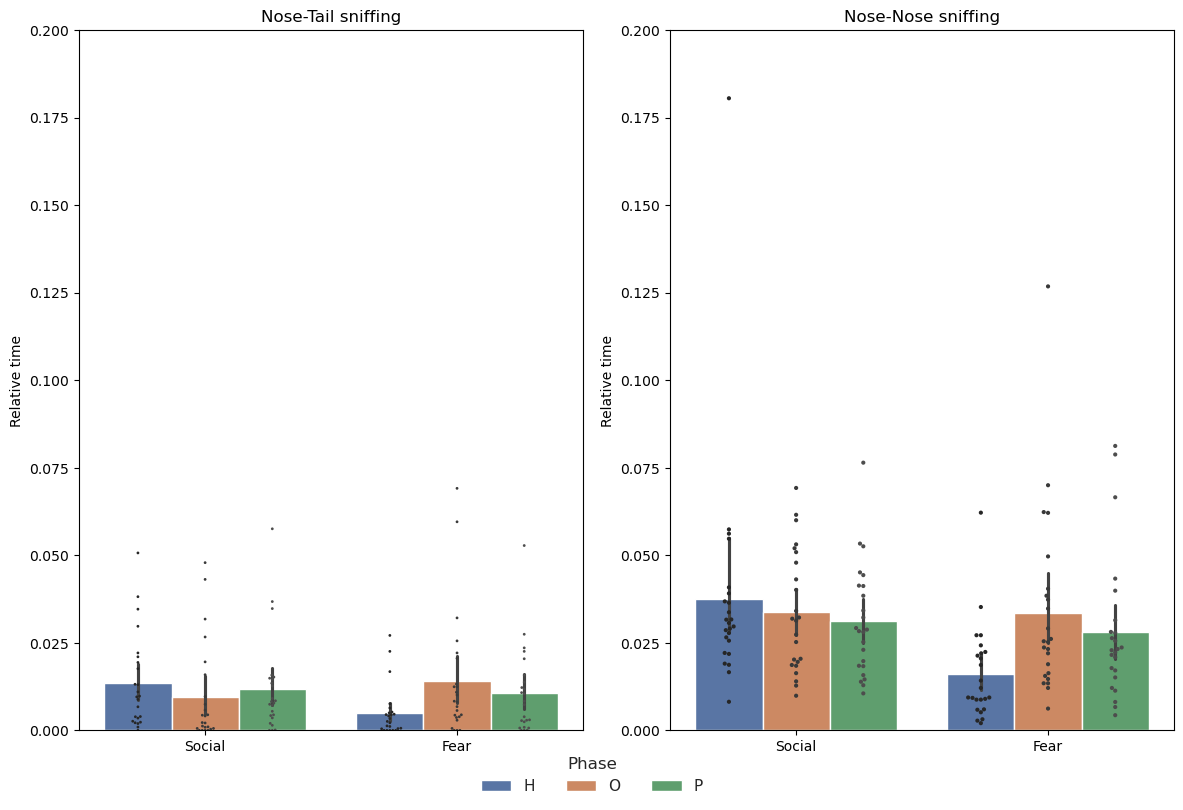

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot for nose-tail
sns.set(style="whitegrid")
sns.barplot(x="odor", y="nose-tail_rt", hue="phase", data=trial, ax=axes[0])
axes[0].set_title('Nose-Tail sniffing')
axes[0].set_ylabel('Relative time')
axes[0].set_xlabel(' ')
axes[0].set_xticklabels({'Social':"S", "Fear":"F"})
axes[0].set_ylim(0, 0.2)  
sns.swarmplot(x="odor", y="nose-tail_rt", hue="phase", data=trial, dodge=True, size=2, color=".3", ax=axes[0], legend=False)
axes[0].legend([],[], frameon=False)

# Plot for nose-nose
sns.barplot(x="odor", y="nose-nose_rt", hue="phase", data=trial, ax=axes[1])
axes[1].set_title('Nose-Nose sniffing')
axes[1].set_ylabel('Relative time')
axes[1].set_xlabel(' ')
axes[1].set_xticklabels({'Social':"S", "Fear":"F"})
axes[1].set_ylim(0, 0.2)  
sns.swarmplot(x="odor", y="nose-nose_rt", hue="phase", data=trial, dodge=True, size=3, color=".3", ax=axes[1], legend=False)
axes[1].legend([],[], frameon=False)

# display legend below the plots (horizontal 1 line, only for the barplots)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend_.remove()
axes[1].legend_.remove()

# Add centered legend across both subplots
fig.legend(
    handles, labels,
    title="Phase",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),  # center of figure (0.5), slightly below plots
    ncol=len(labels),
    frameon=False
)
plt.tight_layout()
plt.show()

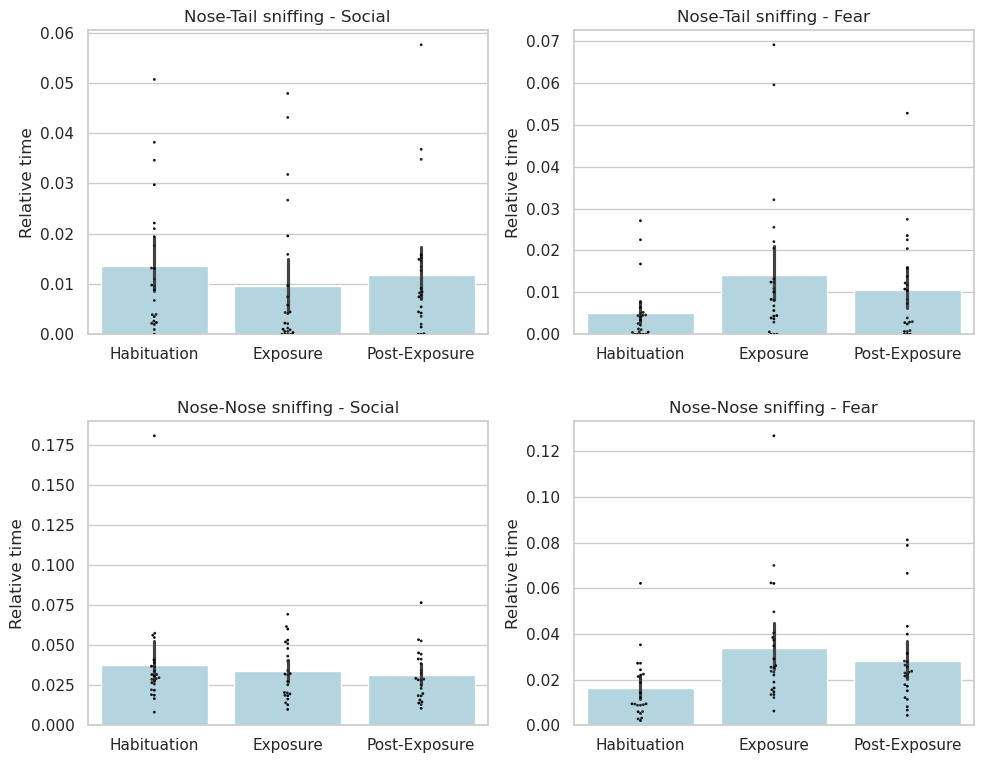

In [10]:
unique_genes = trial["gene"].unique()
gene_palette = dict(zip(unique_genes, sns.color_palette("husl", len(unique_genes)))) 

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Define the dodge offset for swarmplot
dodge_offset = {'first': -0.2, 'second': 0.2}

# Plot for Nose-Tail sniffing - Social
# barplot in light blue
sns.barplot(x="phase", y="nose-tail_rt", data=trial[trial["odor"] == "S"], ax=axes[0, 0], color="lightblue")
sns.swarmplot(x="phase", y="nose-tail_rt", hue="gene", data=trial[trial["odor"] == "S"], dodge=False, size=2, color="black", ax=axes[0, 0])
axes[0, 0].set_title('Nose-Tail sniffing - Social')
axes[0, 0].set_ylabel('Relative time')
axes[0, 0].set_xlabel(' ')
axes[0, 0].set_xticklabels({'Habituation':"H", "Exposure":"O", "Post-Exposure":"P"})
axes[0, 0].legend([],[], frameon=False)

# Plot for Nose-Tail sniffing - Fear
sns.barplot(x="phase", y="nose-tail_rt", data=trial[trial["odor"] == "F"], ax=axes[0, 1], color="lightblue")
sns.swarmplot(x="phase", y="nose-tail_rt", hue="gene", data=trial[trial["odor"] == "F"], dodge=False, size=2, color="black", ax=axes[0, 1])
axes[0, 1].set_title('Nose-Tail sniffing - Fear')
axes[0, 1].set_ylabel('Relative time')
axes[0, 1].set_xlabel(' ')
axes[0, 1].set_xticklabels({'Habituation':"H", "Exposure":"O", "Post-Exposure":"P"})
axes[0, 1].legend([],[], frameon=False)

# Plot for Nose-Nose sniffing - Social
sns.barplot(x="phase", y="nose-nose_rt", data=trial[trial["odor"] == "S"], ax=axes[1, 0], color="lightblue")
sns.swarmplot(x="phase", y="nose-nose_rt", hue="gene", data=trial[trial["odor"] == "S"], dodge=False, size=2, color="black", ax=axes[1, 0])
axes[1, 0].set_title('Nose-Nose sniffing - Social')
axes[1, 0].set_ylabel('Relative time')
axes[1, 0].set_xlabel(' ')
axes[1, 0].set_xticklabels({'Habituation':"H", "Exposure":"O", "Post-Exposure":"P"})
axes[1, 0].legend([],[], frameon=False)

# Plot for Nose-Nose sniffing - Fear
sns.barplot(x="phase", y="nose-nose_rt", data=trial[trial["odor"] == "F"], ax=axes[1, 1], color="lightblue")
sns.swarmplot(x="phase", y="nose-nose_rt", hue="gene", data=trial[trial["odor"] == "F"], dodge=False, size=2, color="black", ax=axes[1, 1])
axes[1, 1].set_title('Nose-Nose sniffing - Fear')
axes[1, 1].set_ylabel('Relative time')
axes[1, 1].set_xlabel(' ')
axes[1, 1].set_xticklabels({'Habituation':"H", "Exposure":"O", "Post-Exposure":"P"})
axes[1, 1].legend([],[], frameon=False)

plt.tight_layout()
# handles, labels = axes[0, 0].get_legend_handles_labels()
# labels = ["wild", "ash1l", "kdm6b", "kmt5b"]
# fig.legend(
#     handles, labels, title='Gene', loc='lower center',
#     bbox_to_anchor=(0.5, -0.05), ncol=len(unique_genes), frameon=True)
# plt.show()
fig.savefig('results/pa_avg.png', dpi=300)

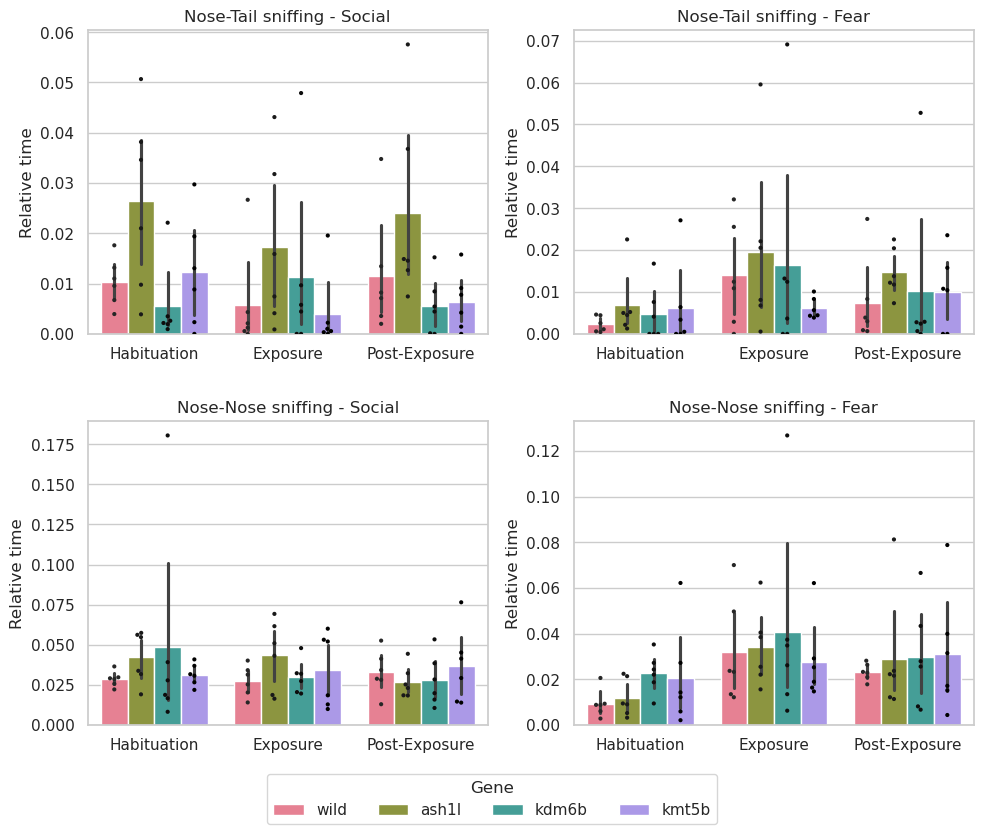

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
dodge_offset = {'first': -0.2, 'second': 0.2}

unique_genes = trial["gene"].unique()
gene_palette = dict(zip(unique_genes, sns.color_palette("husl", len(unique_genes))))

def plot_subplot(ax, odor, y_col, title):
    sns.barplot(x="phase", y=y_col, hue="gene", data=trial[trial["odor"] == odor], ax=ax, palette=gene_palette)
    sns.swarmplot(x="phase", y=y_col, hue="gene", data=trial[trial["odor"] == odor], dodge=True, size=3, color="black", ax=ax, legend=False)
    ax.set_title(title)
    ax.set_ylabel('Relative time')
    ax.set_xlabel(' ')
    ax.set_xticklabels({'Habituation':"H", "Exposure":"O", "Post-Exposure":"P"})
    ax.legend([], [], frameon=False)  # Hide subplot legends

plot_subplot(axes[0, 0], "S", "nose-tail_rt", "Nose-Tail sniffing - Social")
plot_subplot(axes[0, 1], "F", "nose-tail_rt", "Nose-Tail sniffing - Fear")
plot_subplot(axes[1, 0], "S", "nose-nose_rt", "Nose-Nose sniffing - Social")
plot_subplot(axes[1, 1], "F", "nose-nose_rt", "Nose-Nose sniffing - Fear")

plt.tight_layout()

handles, labels = axes[0, 0].get_legend_handles_labels()
labels = ["wild", "ash1l", "kdm6b", "kmt5b"]
fig.legend(
    handles, labels, title='Gene', loc='lower center',
    bbox_to_anchor=(0.5, -0.05), ncol=len(unique_genes), frameon=True)
plt.show()
fig.savefig('results/pa_gene.png', dpi=300, bbox_inches='tight')

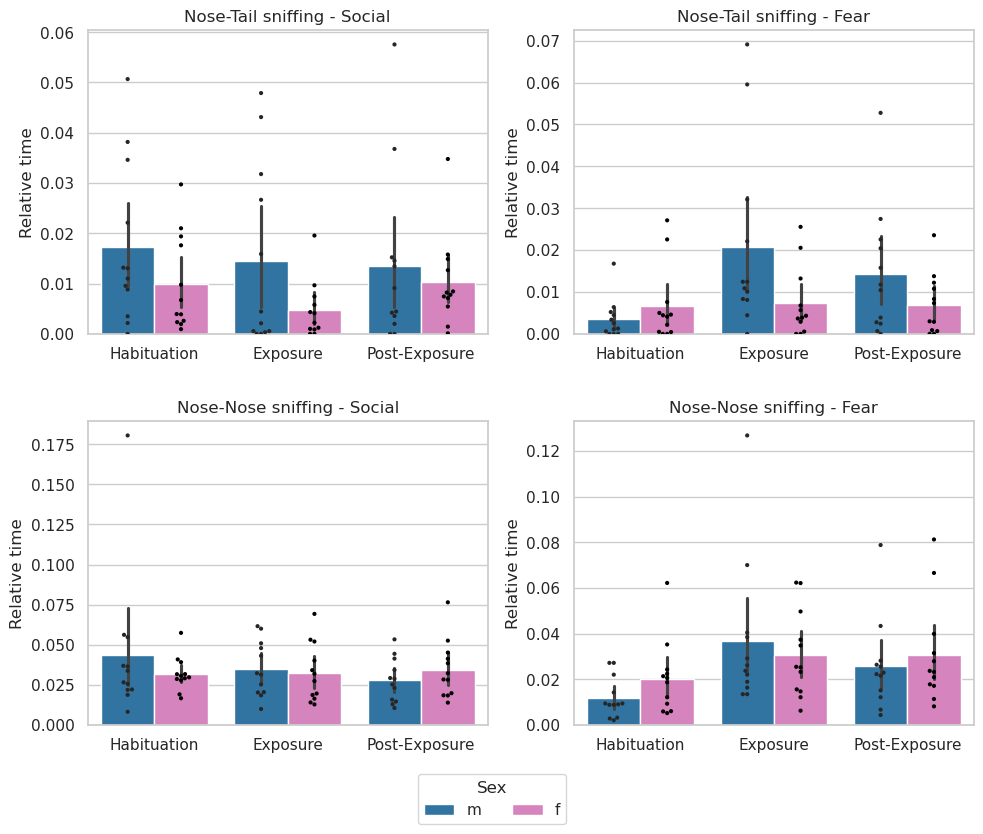

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
dodge_offset = {'first': -0.2, 'second': 0.2}

unique_sex = trial["sex"].unique()
sex_palette = {'f': '#E377C2', 'm': '#1F77B4'}

def plot_subplot(ax, odor, y_col, title):
    sns.barplot(x="phase", y=y_col, hue="sex", data=trial[trial["odor"] == odor], ax=ax, palette=sex_palette)
    sns.swarmplot(x="phase", y=y_col, hue="sex", data=trial[trial["odor"] == odor], dodge=True, size=3, color="black", ax=ax, legend=False)
    ax.set_title(title)
    ax.set_ylabel('Relative time')
    ax.set_xlabel(' ')
    ax.set_xticklabels({'Habituation':"H", "Exposure":"O", "Post-Exposure":"P"})
    ax.legend([], [], frameon=False)  # Hide subplot legends

plot_subplot(axes[0, 0], "S", "nose-tail_rt", "Nose-Tail sniffing - Social")
plot_subplot(axes[0, 1], "F", "nose-tail_rt", "Nose-Tail sniffing - Fear")
plot_subplot(axes[1, 0], "S", "nose-nose_rt", "Nose-Nose sniffing - Social")
plot_subplot(axes[1, 1], "F", "nose-nose_rt", "Nose-Nose sniffing - Fear")

plt.tight_layout()

handles, labels = axes[0, 0].get_legend_handles_labels()
#labels = ["wild", "ash1l", "kdm6b", "kmt5b"]
fig.legend(
    handles, labels, title='Sex', loc='lower center',
    bbox_to_anchor=(0.5, -0.05), ncol=len(unique_sex), frameon=True)
plt.show()
fig.savefig('results/pa_sex.png', dpi=300, bbox_inches='tight')